### 2021年春 模式识别与机器学习 项目 心跳信号分类预测
### 山东大学 计算机科学与技术学院 智能19 李阳

In [1]:
# 包含所需要的库
# 关于如何直接导出ipynb为pdf且支持中文的参考https://www.cnblogs.com/myfy/p/12829122.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from math import sqrt
from math import exp
from math import pi
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#### 查看数据信息

In [2]:
train_data=pd.read_csv('./train.csv') # 训练集
testA_data=pd.read_csv('./testA.csv') # 测试集
print(train_data.shape)
train_data.head().append(train_data.tail()) # 查看数据的行列信息

(100000, 3)


,id,heartbeat_signals,label
0,0,"0.9912297987616655,0.9435330436439665,0.764677...",0.0
1,1,"0.9714822034884503,0.9289687459588268,0.572932...",0.0
2,2,"1.0,0.9591487564065292,0.7013782792997189,0.23...",2.0
3,3,"0.9757952826275774,0.9340884687738161,0.659636...",0.0
4,4,"0.0,0.055816398940721094,0.26129357194994196,0...",2.0
99995,99995,"1.0,0.677705342021188,0.22239242747868546,0.25...",0.0
99996,99996,"0.9268571578157265,0.9063471198026871,0.636993...",2.0
99997,99997,"0.9258351628306013,0.5873839035878395,0.633226...",3.0
99998,99998,"1.0,0.9947621698382489,0.8297017704865509,0.45...",2.0
99999,99999,"0.9259994004527861,0.916476635326053,0.4042900...",0.0


In [3]:
train_data.info # 数据类型

<bound method DataFrame.info of           id                                  heartbeat_signals  label
0          0  0.9912297987616655,0.9435330436439665,0.764677...    0.0
1          1  0.9714822034884503,0.9289687459588268,0.572932...    0.0
2          2  1.0,0.9591487564065292,0.7013782792997189,0.23...    2.0
3          3  0.9757952826275774,0.9340884687738161,0.659636...    0.0
4          4  0.0,0.055816398940721094,0.26129357194994196,0...    2.0
...      ...                                                ...    ...
99995  99995  1.0,0.677705342021188,0.22239242747868546,0.25...    0.0
99996  99996  0.9268571578157265,0.9063471198026871,0.636993...    2.0
99997  99997  0.9258351628306013,0.5873839035878395,0.633226...    3.0
99998  99998  1.0,0.9947621698382489,0.8297017704865509,0.45...    2.0
99999  99999  0.9259994004527861,0.916476635326053,0.4042900...    0.0

[100000 rows x 3 columns]>

In [4]:
train_data.isnull().sum() # 检查是否有缺省值

id                   0
heartbeat_signals    0
label                0
dtype: int64

In [5]:
train_data['label'].value_counts() # 查看预测值的分布情况

0.0    64327
3.0    17912
2.0    14199
1.0     3562
Name: label, dtype: int64

#### 数据处理

In [6]:
# 修改数据类型节省内存，将category类代替object类
def dataProcess(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    return df

In [7]:
# 将题目中所给的heartbeat-signal信息重新整理，并对内存进行优化
train_list=[]
for items in train_data.values:
    train_list.append([items[0]]+[float(i) for i in items[1].split(',')]+[items[2]])
train_data=pd.DataFrame(np.array(train_list))
train_data.columns=['id']+['t'+str(i) for i in range(len(train_list[0])-2)]+['label']
train_data=dataProcess(train_data)

testA_list=[]
for items in testA_data.values:
    testA_list.append([items[0]]+[float(i) for i in items[1].split(',')])
testA_data=pd.DataFrame(np.array(testA_list))
testA_data.columns=['id']+['t'+str(i) for i in range(len(testA_list[0])-1)]
testA_data=dataProcess(testA_data)

train_data.head().append(train_data.tail())

,id,t0,t1,t2,t3,t4,t5,t6,t7,t8,...,t196,t197,t198,t199,t200,t201,t202,t203,t204,label
0,0.0,0.991211,0.943359,0.764648,0.618652,0.379639,0.190796,0.040222,0.026001,0.031708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.971680,0.929199,0.572754,0.178467,0.122986,0.132324,0.094421,0.089600,0.030487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.000000,0.958984,0.701172,0.231812,0.000000,0.080688,0.128418,0.187500,0.280762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3.0,0.975586,0.934082,0.659668,0.249878,0.237061,0.281494,0.249878,0.249878,0.241455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.000000,0.055817,0.261230,0.359863,0.433105,0.453613,0.499023,0.542969,0.616699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
99995,99995.0,1.000000,0.677734,0.222412,0.257080,0.204712,0.054657,0.026154,0.118164,0.244873,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99996,99996.0,0.926758,0.906250,0.637207,0.415039,0.374756,0.382568,0.358887,0.341309,0.336426,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
99997,99997.0,0.925781,0.587402,0.633301,0.632324,0.639160,0.614258,0.599121,0.517578,0.403809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
99998,99998.0,1.000000,0.994629,0.829590,0.458252,0.264160,0.240234,0.213745,0.189331,0.203857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
99999,99999.0,0.925781,0.916504,0.404297,0.000000,0.262939,0.385498,0.361084,0.332764,0.339844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# 去掉id和label，用于模型拟合
x_train=train_data.drop(['id','label'], axis=1)
y_train=train_data['label']
x_test=testA_data.drop(['id'], axis=1)

x_train

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t195,t196,t197,t198,t199,t200,t201,t202,t203,t204
0,0.991211,0.943359,0.764648,0.618652,0.379639,0.190796,0.040222,0.026001,0.031708,0.065552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.971680,0.929199,0.572754,0.178467,0.122986,0.132324,0.094421,0.089600,0.030487,0.040497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.958984,0.701172,0.231812,0.000000,0.080688,0.128418,0.187500,0.280762,0.328369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.975586,0.934082,0.659668,0.249878,0.237061,0.281494,0.249878,0.249878,0.241455,0.230713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.055817,0.261230,0.359863,0.433105,0.453613,0.499023,0.542969,0.616699,0.676758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.000000,0.677734,0.222412,0.257080,0.204712,0.054657,0.026154,0.118164,0.244873,0.328857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99996,0.926758,0.906250,0.637207,0.415039,0.374756,0.382568,0.358887,0.341309,0.336426,0.317139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99997,0.925781,0.587402,0.633301,0.632324,0.639160,0.614258,0.599121,0.517578,0.403809,0.253174,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99998,1.000000,0.994629,0.829590,0.458252,0.264160,0.240234,0.213745,0.189331,0.203857,0.210815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 模型拟合

In [9]:
feature_train, feature_test, label_train, label_test = train_test_split(x_train, y_train, test_size = 0.98, random_state = 10)

In [14]:
# adaboost + decision tree
def get_model():
    """
    产生弱分类器
    """
    models=dict()
    for i in range(1,11):
        models[str(i)]=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=i))
    return models

def evaluate_model(model):
    """
    使用交叉检验评估模型
    """
    cv=RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=1)
    scores=cross_val_score(model,feature_train,label_train,scoring='accuracy',cv=cv, n_jobs=-1, error_score='raise')
    return scores


models=get_model()
results,names=[],[]
for name,model in models.items():
    scores=evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('层数>%s 精确度均值: %.3f 精确度方差: %.3f' % (name, np.mean(scores), np.std(scores)))

层数>1 精确度均值: 0.650 精确度方差: 0.059
层数>2 精确度均值: 0.767 精确度方差: 0.047
层数>3 精确度均值: 0.873 精确度方差: 0.027
层数>4 精确度均值: 0.926 精确度方差: 0.018
层数>5 精确度均值: 0.938 精确度方差: 0.013
层数>6 精确度均值: 0.947 精确度方差: 0.010
层数>7 精确度均值: 0.947 精确度方差: 0.013
层数>8 精确度均值: 0.951 精确度方差: 0.013
层数>9 精确度均值: 0.951 精确度方差: 0.014
层数>10 精确度均值: 0.950 精确度方差: 0.012


In [16]:
# adaboost + svm
svm=SVC(probability=True,kernel='linear')
model=AdaBoostClassifier(base_estimator=svm)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores=cross_val_score(model, feature_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('准确率均值: %.3f 方差：%.3f' % (np.mean(n_scores), np.std(n_scores)))

准确率均值: 0.648 方差：0.002


In [20]:
# 保存一下n_scores的值...不用下次再跑四十多分钟了
n_scores_copy=np.array([0.65 , 0.65 , 0.65 , 0.65 , 0.65 , 0.65 , 0.65 , 0.645, 0.645, 0.645, 0.65 , 0.65 , 0.65 , 0.65 , 0.65 , 0.65 , 0.65 , 0.645, 0.645, 0.645, 0.65 , 0.65 , 0.65 , 0.65 , 0.65 , 0.65 , 0.65 ,0.645, 0.645, 0.645])
n_scores_copy

array([0.65 , 0.65 , 0.65 , 0.65 , 0.65 , 0.65 , 0.65 , 0.645, 0.645,
       0.645, 0.65 , 0.65 , 0.65 , 0.65 , 0.65 , 0.65 , 0.65 , 0.645,
       0.645, 0.645, 0.65 , 0.65 , 0.65 , 0.65 , 0.65 , 0.65 , 0.65 ,
       0.645, 0.645, 0.645])

In [13]:
# 随机森林
rfc_model=RandomForestClassifier()
rfc_scores=cross_val_score(rfc_model,feature_train,label_train,cv=10)
print('准确率均值: %.3f 方差：%.3f' % (np.mean(rfc_scores), np.std(rfc_scores)))

准确率均值: 0.945 方差：0.016


#### 最终选择使用随机森林进行模型拟合

0.9484999999999999 71


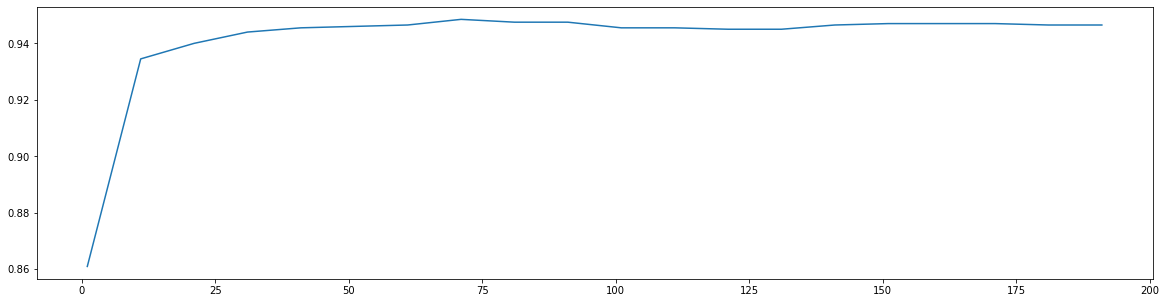

In [15]:
# 以10为分割点，用交叉验证来调整n_estimator
score1=[]
for i in range(0,200,10):
    rfc=RandomForestClassifier(n_estimators=i+1,n_jobs=-1,random_state=90)
    score=cross_val_score(rfc,feature_train,label_train,cv=10).mean()
    score1.append(score)
print(max(score1),(score1.index(max(score1))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),score1)
plt.show()

0.9485000000000001 72


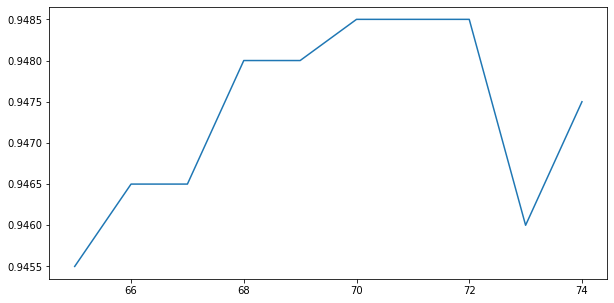

In [8]:
# 可以看到在71左右为最优点，进一步细化
score1=[]
for i in range(65,75):
    rfc=RandomForestClassifier(n_estimators=i,n_jobs=-1,random_state=90)
    score=cross_val_score(rfc,feature_train,label_train,cv=10).mean()
    score1.append(score)
print(max(score1),([*range(65,75)][score1.index(max(score1))]))
plt.figure(figsize=[10,5])
plt.plot(range(65,75),score1)
plt.show()

In [12]:
# 用随机搜索来寻找其余的最优参数
rfc=RandomForestClassifier(n_estimators=72,random_state=90)
params=[{'max_depth':np.arange(11,50,1)},{'max_features':np.arange(5,50,1)},{'min_samples_leaf':np.arange(1, 1+50, 1)},{'min_samples_split':np.arange(2, 2+50, 1)}]
for dic in params:
    bestModel=GridSearchCV(rfc,param_grid=dic,cv=10,n_jobs = -1)
    bestModel.fit(feature_train,label_train)
    print('最优分类器:',bestModel.best_params_,'最优分数:', bestModel.best_score_)

最优分类器: {'max_depth': 24} 最优分数: 0.9485000000000001
最优分类器: {'max_features': 30} 最优分数: 0.9495000000000001
最优分类器: {'min_samples_leaf': 1} 最优分数: 0.9485000000000001
最优分类器: {'min_samples_split': 3} 最优分数: 0.9490000000000001


In [15]:
# 确定最终模型
rfc=RandomForestClassifier(n_estimators=72,max_features=30,random_state=90)
cv=RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=1)
rfc_scores=cross_val_score(rfc,feature_train,label_train,cv=10)
print('准确率均值: %.3f 方差：%.3f' % (np.mean(rfc_scores), np.std(rfc_scores)))

准确率均值: 0.950 方差：0.014
